<a href="https://colab.research.google.com/github/clyde2020/ML_Portfolio/blob/main/Kaggle_Histopathologic_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
import random
!pip install keras-tuner -q
from keras_tuner import RandomSearch
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
#from sklearn.model_selection import RandomizedSearchCV

from google.colab import drive
drive.mount('/content/gdrive')

     |████████████████████████████████| 98 kB 6.1 MB/s 
Mounted at /content/gdrive


To set source folders before splitting

In [ ]:
#source_small_folder = '/content/gdrive/MyDrive/Histopath/small_set'
#source_large_folder = '/content/gdrive/MyDrive/Histopath/large_set'
#source_grid_folder = '/content/gdrive/MyDrive/Histopath/grid_set'

#print(len(os.listdir(source_small_folder)))
#print(len(os.listdir(source_large_folder)))
#print(len(os.listdir(source_grid_folder)))

Read in the labels

In [2]:
df = pd.read_csv('/content/gdrive/MyDrive/Histopath/train_labels.csv')
print(len(df.id))

picdict = dict(zip(df['id'], df['label']))

220025


Set data folder variables

In [3]:
# Update these variables according to the dataset to use
train_comp = '/content/gdrive/MyDrive/Histopath/Grid/Train'
valid_comp = '/content/gdrive/MyDrive/Histopath/Grid/Valid'
benign_train_comp = '/content/gdrive/MyDrive/Histopath/Grid/Train/Benign'
benign_valid_comp = '/content/gdrive/MyDrive/Histopath/Grid/Valid/Benign'
mal_train_comp = '/content/gdrive/MyDrive/Histopath/Grid/Train/Malignant'
mal_valid_comp = '/content/gdrive/MyDrive/Histopath/Grid/Valid/Malignant'

Folder creation before split data

In [ ]:
#os.mkdir('/content/Lymph')
#os.mkdir('/content/Lymph/Train')
#os.mkdir('/content/Lymph/Valid')
#os.mkdir('/content/Lymph/Train/Benign')
#os.mkdir('/content/Lymph/Train/Malignant')
#os.mkdir('/content/Lymph/Valid/Benign')
#os.mkdir('/content/Lymph/Valid/Malignant')


#train_folder = '/content/Lymph/Train'
#valid_folder = '/content/Lymph/Valid'
#benign_train = '/content/Lymph/Train/Benign'
#benign_valid = '/content/Lymph/Valid/Benign'
#mal_train = '/content/Lymph/Train/Malignant'
#mal_valid = '/content/Lymph/Valid/Malignant'



Shuffle the data and set up lists before split data

In [ ]:
#shuffled_small = random.sample(os.listdir(source_small_folder), len(os.listdir(source_small_folder)))
#shuffled_large = random.sample(os.listdir(source_large_folder), len(os.listdir(source_large_folder)))
#shuffled_grid = random.sample(os.listdir(source_grid_folder), len(os.listdir(source_grid_folder)))

#valid_number = 800  #This value must be updated according to the dataset
#valid_list = shuffled_small[:valid_number]
#train_list = shuffled_small[valid_number:]

#print(train_list[0:5])
#print(len(train_list))

['1a698cf2fdbb3a048ec8ccf652063659857f4c55.tif', '1df13f7879cc3c023b3b1f0084ac8e3a003e415e.tif', '1a1a7b0ec4f4860f1a556c6fe1bb25da0f54d216.tif', '1a1d5195a7b796d3c4a66ce273ec6d3f42cb7094.tif', '1bb5fd5e86d6d90f494e0d8f8c8be7752caa3ba5.tif']
3544


This function splits the dataset into malignant and benign

In [ ]:
def split_data(LIST, SOURCE, MAL_FOLDER, BENIGN_FOLDER):
  for fname in LIST:
    origin = os.path.join(SOURCE, fname)
    name = os.path.splitext(os.path.basename(fname))[0]
    if os.path.getsize(origin) > 1:
      if picdict[name] == 0:
        shutil.copy(origin, BENIGN_FOLDER)
      else:
        shutil.copy(origin, MAL_FOLDER)

In [ ]:
#os.mkdir('/content/gdrive/MyDrive/Histopath/Small')
#os.mkdir('/content/gdrive/MyDrive/Histopath/Small/Train')
#os.mkdir('/content/gdrive/MyDrive/Histopath/Small/Valid')
#os.mkdir('/content/gdrive/MyDrive/Histopath/Small/Train/Benign')
#os.mkdir('/content/gdrive/MyDrive/Histopath/Small/Valid/Benign')
#os.mkdir('/content/gdrive/MyDrive/Histopath/Small/Train/Malignant')
#os.mkdir('/content/gdrive/MyDrive/Histopath/Small/Valid/Malignant')

In [ ]:
#split_data(valid_list, source_small_folder, mal_valid_comp, benign_valid_comp)
#split_data(train_list, source_small_folder, mal_train_comp, benign_train_comp)

Code for moving the data instead of copying (only used once)

In [ ]:
def move_data(LIST, SOURCE, DESTINATION):
  for fname in LIST:
    origin = os.path.join(SOURCE, fname)
    shutil.copy(origin, DESTINATION)

In [ ]:
train_benign_list = os.listdir(benign_train)
train_mal_list = os.listdir(mal_train)
valid_benign_list = os.listdir(benign_valid)
valid_mal_list = os.listdir(mal_valid)

In [ ]:
move_data(train_benign_list, benign_train, benign_train_comp)

In [ ]:
move_data(train_mal_list, mal_train, mal_train_comp)
move_data(valid_benign_list, benign_valid, benign_valid_comp)
move_data(valid_mal_list, mal_valid, mal_valid_comp)

Confirm we have the data in the correct spot

In [4]:
print(len(os.listdir(benign_train_comp)))
print(len(os.listdir(mal_train_comp)))
print(len(os.listdir(benign_valid_comp)))
print(len(os.listdir(mal_valid_comp)))

558
351
59
41


Data Augmentation

In [5]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                  rotation_range=45,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_comp,
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1/255.0)  

validation_generator = validation_datagen.flow_from_directory(
    valid_comp,
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary') 

Found 909 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Model with LR scheduler, only for small set

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, 3, input_shape=(96, 96, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(160, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(224, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
                          
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 5))
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)
#model.compile(loss=tf.keras.losses.Huber(),
#              optimizer=optimizer,
#              metrics=["mae"])


model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['acc'])

model.summary()

In [ ]:
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    callbacks=[lr_schedule],
                    validation_data=validation_generator)

(1e-05, 0.1, 0.0, 1.0)

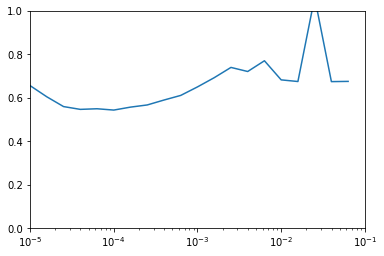

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 1])

Use Keras Tuner to get best model hyperparameters

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)

def build_model(hp):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(filters=hp.Choice('filters1',
                             values=[96, 128, 160, 192]), 
                             kernel_size=3, 
                             input_shape=(96, 96, 3), 
                             activation='relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(filters=hp.Choice('filters2',
                             values=[160, 192, 224, 256]), 
                             kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(filters=hp.Choice('filters3',
                             values=[160, 192, 224, 256, 288, 320]), 
                             kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPooling2D(2),
                            
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=hp.Choice('units',
                            values=[800, 1000, 2000, 4000]), activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

  return model

In [7]:
tuner = RandomSearch(
    build_model,
    objective="acc",
    max_trials=12,
    executions_per_trial=1,
    overwrite=True,
    #directory="keras_tuner_directory",
    project_name="Cancer_Detection",
)

In [8]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
filters1 (Choice)
{'default': 96, 'conditions': [], 'values': [96, 128, 160, 192], 'ordered': True}
filters2 (Choice)
{'default': 160, 'conditions': [], 'values': [160, 192, 224, 256], 'ordered': True}
filters3 (Choice)
{'default': 160, 'conditions': [], 'values': [160, 192, 224, 256, 288, 320], 'ordered': True}
units (Choice)
{'default': 800, 'conditions': [], 'values': [800, 1000, 2000, 4000], 'ordered': True}


In [9]:
tuner.search(train_generator, epochs=120, validation_data=validation_generator)

Trial 12 Complete [00h 08m 42s]
acc: 0.8580858111381531

Best acc So Far: 0.8734873533248901
Total elapsed time: 01h 50m 59s
INFO:tensorflow:Oracle triggered exit


In [10]:
tuner.results_summary(6)

Results summary
Results in ./Cancer_Detection
Showing 6 best trials
Objective(name='acc', direction='max')
Trial summary
Hyperparameters:
filters1: 160
filters2: 224
filters3: 160
units: 2000
Score: 0.8734873533248901
Trial summary
Hyperparameters:
filters1: 192
filters2: 192
filters3: 160
units: 4000
Score: 0.8701870441436768
Trial summary
Hyperparameters:
filters1: 192
filters2: 160
filters3: 224
units: 4000
Score: 0.8690869212150574
Trial summary
Hyperparameters:
filters1: 192
filters2: 256
filters3: 288
units: 1000
Score: 0.8635863661766052
Trial summary
Hyperparameters:
filters1: 160
filters2: 160
filters3: 224
units: 4000
Score: 0.8635863661766052
Trial summary
Hyperparameters:
filters1: 192
filters2: 256
filters3: 256
units: 2000
Score: 0.8624862432479858


Model with callbacks, for large set

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, 3, input_shape=(96, 96, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(160, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(224, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
                          
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='acc', min_delta=0.01, patience=30,
                   verbose=1, mode='auto')
mc = ModelCheckpoint(monitor='acc', filepath='./bestmodel.h5', 
                     verbose=1, save_best_only=True, mode='auto')

cd = [es, mc]
history = model.fit(train_generator,
                    epochs=500,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=cd)

Epoch 1/500
450/450 [==============================] - ETA: 0s - loss: 0.5233 - acc: 0.7433
Epoch 00001: acc improved from -inf to 0.74334, saving model to ./bestmodel.h5
450/450 [==============================] - 90s 132ms/step - loss: 0.5233 - acc: 0.7433 - val_loss: 0.4607 - val_acc: 0.7835
Epoch 2/500
450/450 [==============================] - ETA: 0s - loss: 0.4758 - acc: 0.7797
Epoch 00002: acc improved from 0.74334 to 0.77966, saving model to ./bestmodel.h5
450/450 [==============================] - 59s 130ms/step - loss: 0.4758 - acc: 0.7797 - val_loss: 0.5085 - val_acc: 0.7620
Epoch 3/500
450/450 [==============================] - ETA: 0s - loss: 0.4630 - acc: 0.7896
Epoch 00003: acc improved from 0.77966 to 0.78961, saving model to ./bestmodel.h5
450/450 [==============================] - 58s 129ms/step - loss: 0.4630 - acc: 0.7896 - val_loss: 0.5464 - val_acc: 0.7625
Epoch 4/500
450/450 [==============================] - ETA: 0s - loss: 0.4509 - acc: 0.7938
Epoch 00004: acc 

In [ ]:
model = load_model('/content/bestmodel.h5')

In [ ]:
h = history.history
h.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

Model results with Adam optimizer, we need to add regularization

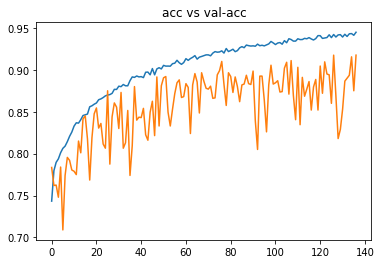

In [ ]:
plt.plot(h['acc'])
plt.plot(h['val_acc'])
plt.title('acc vs val-acc')
plt.show()

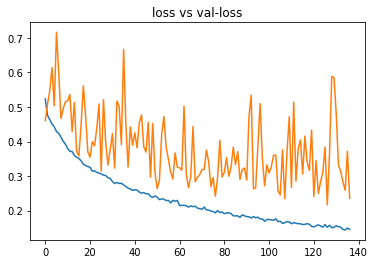

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('loss vs val-loss')
plt.show()

Model with regularization and Gridsearch; 
use with small set

In [ ]:
#  Put code here for headline

In [ ]:
def build_model(hp):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(filters=hp.Choice('filters1',
                             values=[32, 64, 96, 128, 160]), 
                             kernel_size=3, 
                             input_shape=(96, 96, 3), 
                             activation='relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(filters=128,
                             kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(filters=192,
                             kernel_size=3, activation='relu'),
      tf.keras.layers.MaxPooling2D(2),
                            
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units=320, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])


In [ ]:
h = history.history
h.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

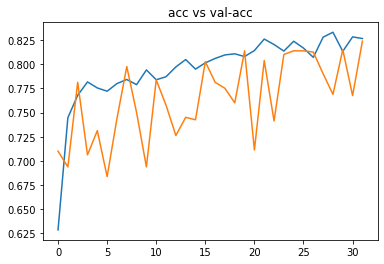

In [ ]:
plt.plot(h['acc'])
plt.plot(h['val_acc'])
plt.title('acc vs val-acc')
plt.show()

In [ ]:
tuner = RandomSearch(
    build_model,
    objective="acc",
    max_trials=50,
    #executions_per_trial=1,
    #overwrite=True,
    #directory="keras_tuner_directory",
    #project_name="Q5_experiment",
)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
filters1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 96, 128, 160], 'ordered': True}


In [ ]:
tuner.search(train_image, train_label, epochs=150)  #, validation_data=(valid_image, valid_label))
#tuner.results_summary()


Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
filters1          |96                |?                 



RuntimeError: ignored

In [ ]:
history = model.fit(train_generator,
                    epochs=80,
                    verbose=1,
                    callbacks=[lr_schedule])

(1e-05, 0.1, 0.0, 1.0)

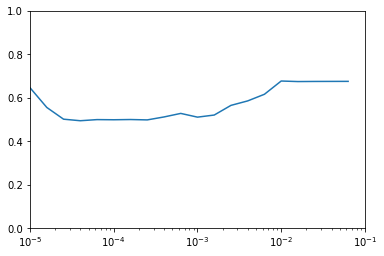

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 1])

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, 3, input_shape=(96, 96, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(160, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(192, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
                          
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator)